In [85]:
import sys, os
import numpy as np
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
sys.path.append("../../scripts/")
from plt_config import use_latex, TU_GREY, TU_RED
import matplotlib.pyplot as plt
use_latex()
BASIS_PATH = "/home/etschgi1/REPOS/Masterarbeit/scripts/6-31g_2df_p_custom_nwchem.gbs"
data_folder = "plot_data"

In [86]:
from matplotlib.colors import SymLogNorm
def plotwithlabels(X, M, plotname, overlay=None, labels="atoms", colorbar=True, labelsize=8, vmax=1):
    if colorbar:
        fig, ax = plt.subplots(1, 2, figsize=(9, 8), gridspec_kw={'width_ratios': [25, 1]})
    else:
        fig, ax0 = plt.subplots(figsize=(9, 8))
        ax = [ax0]  # damit ax[0] weiterhin funktioniert
    norm = SymLogNorm(linthresh=1e-3, linscale=1.0, vmin=-vmax, vmax=vmax)
    im = ax[0].imshow(X, cmap='RdBu', norm=norm)

    if labels == "atoms":
        from collections import defaultdict
        atom_groups = defaultdict(list)
        for i, label in enumerate(M.ao_labels()):
            key = ' '.join(label.split()[:2])  # z.B. "2 O"
            atom_groups[key].append(i)

        new_ticks = [np.mean(indices) for indices in atom_groups.values()]
        labels_ = [f"{k.split()[1]}$_{{{k.split()[0]}}}$" for k in atom_groups.keys()]
        ax[0].set_xticks(new_ticks)
        ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
        ax[0].set_yticks(new_ticks)
        ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
        ax[0].tick_params(axis='x', labelbottom=True, pad=10 + labelsize)
        ax[0].tick_params(axis='y', labelleft=True, pad=10 + labelsize)

    elif labels == "all":
        labels_ = [f"{label.split()[1]}$_{{{label.split()[0]}}}$: {{{label.split()[2]}}}" for label in M.ao_labels()]
        ax[0].set_xticks(range(len(labels_)))
        ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
        ax[0].set_yticks(range(len(labels_)))
        ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
        ax[0].tick_params(axis='x', labelbottom=True, pad=30)
        ax[0].tick_params(axis='y', labelleft=True, pad=30)

    ax[0].grid(False)

    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]
    boundaries = [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]]
    for b in boundaries:
        ax[0].axhline(b - 0.5, color='gray', lw=0.5)
        ax[0].axvline(b - 0.5, color='gray', lw=0.5)

    if colorbar:
        cb = plt.colorbar(im, cax=ax[1])
        cb.ax.tick_params(labelsize=12)
        cb.ax.grid(False)

    if overlay is not None:
        overlay_img = mpimg.imread(overlay)
        imagebox = OffsetImage(overlay_img, zoom=0.21)
        ab = AnnotationBbox(imagebox, (0.69, 0.72), frameon=False, xycoords='axes fraction')
        ax[0].add_artist(ab)

    plt.savefig(f"{plotname}", bbox_inches="tight", dpi=600)

In [87]:
import matplotlib.patches as mpatches
def add_hatched_region(ax, row_start, row_end, col_start, col_end,
                       hatch='///', edgecolor='gray', linewidth=0):
    width  = col_end - col_start + 1
    height = row_end - row_start + 1
    rect = mpatches.Rectangle(
        (col_start - 0.5, row_start - 0.5),
        width, height,
        fill=False,
        hatch=hatch,
        edgecolor=edgecolor,
        linewidth=linewidth,
        alpha=0.5
    )
    ax.add_patch(rect)

def plotschematicBlocks(X, M, plotname, hatched_regions = [], overlay=None, colorbar=True, labelsize=8, vmax=1):
    if colorbar:
        fig, ax = plt.subplots(1, 2, figsize=(9, 8), gridspec_kw={'width_ratios': [25, 1]})
    else:
        fig, ax0 = plt.subplots(figsize=(9, 8))
        ax = [ax0]  # damit ax[0] weiterhin funktioniert
    norm = SymLogNorm(linthresh=1e-3, linscale=1.0, vmin=-vmax, vmax=vmax)
    im = ax[0].imshow(X, cmap='RdBu', norm=norm)


    labels_ = [f"{label.split()[1]}$_{{{label.split()[0]}}}$: {{{label.split()[2][:2]}}}" for label in M.ao_labels()]
    ax[0].set_xticks(range(len(labels_)))
    ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
    ax[0].set_yticks(range(len(labels_)))
    ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
    ax[0].tick_params(axis='x', labelbottom=True, pad=30)
    ax[0].tick_params(axis='y', labelleft=True, pad=30)

    for label, hatch, row_col_indices in hatched_regions:
        row_start, row_end, col_start, col_end = row_col_indices
        add_hatched_region(ax[0], row_start, row_end, col_start, col_end, hatch=hatch)
        # add distinct hatch label to legend
        
    if hatched_regions:
     seen = {}
     handles = []
     for label, hatch, _ in hatched_regions:
         if hatch not in seen:
             seen[hatch] = label
             patch = mpatches.Patch(
                 facecolor='none',
                 hatch=hatch,
                 edgecolor='gray',
                 linewidth=1,
                 label=label
             )
             handles.append(patch)

     ax[0].legend(
         handles=handles,
         loc='lower center',
         bbox_to_anchor=(0.5, 0.99),
         ncol=len(handles),
         frameon=False,
         fontsize=1.5*labelsize
     )

    ax[0].grid(False)

    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]
    boundaries = [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]]
    for b in boundaries:
        ax[0].axhline(b - 0.5, color=TU_GREY, lw=1.5)
        ax[0].axvline(b - 0.5, color=TU_GREY, lw=1.5)

    if colorbar:
        cb = plt.colorbar(im, cax=ax[1])
        cb.ax.tick_params(labelsize=12)
        cb.ax.grid(False)

    if overlay is not None:
        overlay_img = mpimg.imread(overlay)
        imagebox = OffsetImage(overlay_img, zoom=0.21)
        ab = AnnotationBbox(imagebox, (0.69, 0.72), frameon=False, xycoords='axes fraction')
        ax[0].add_artist(ab)

    plt.savefig(f"{plotname}", bbox_inches="tight", dpi=600)
    

In [88]:
from scf_guess_tools import load, calculate, guess, Backend

In [89]:
filepath = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz/dsgdb9nsd_000003.xyz"
mol = load(filepath, basis=BASIS_PATH, backend=Backend.PY)
wf = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")
density = wf.density()

Using basis from /home/etschgi1/REPOS/Masterarbeit/scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -76.4229927319667


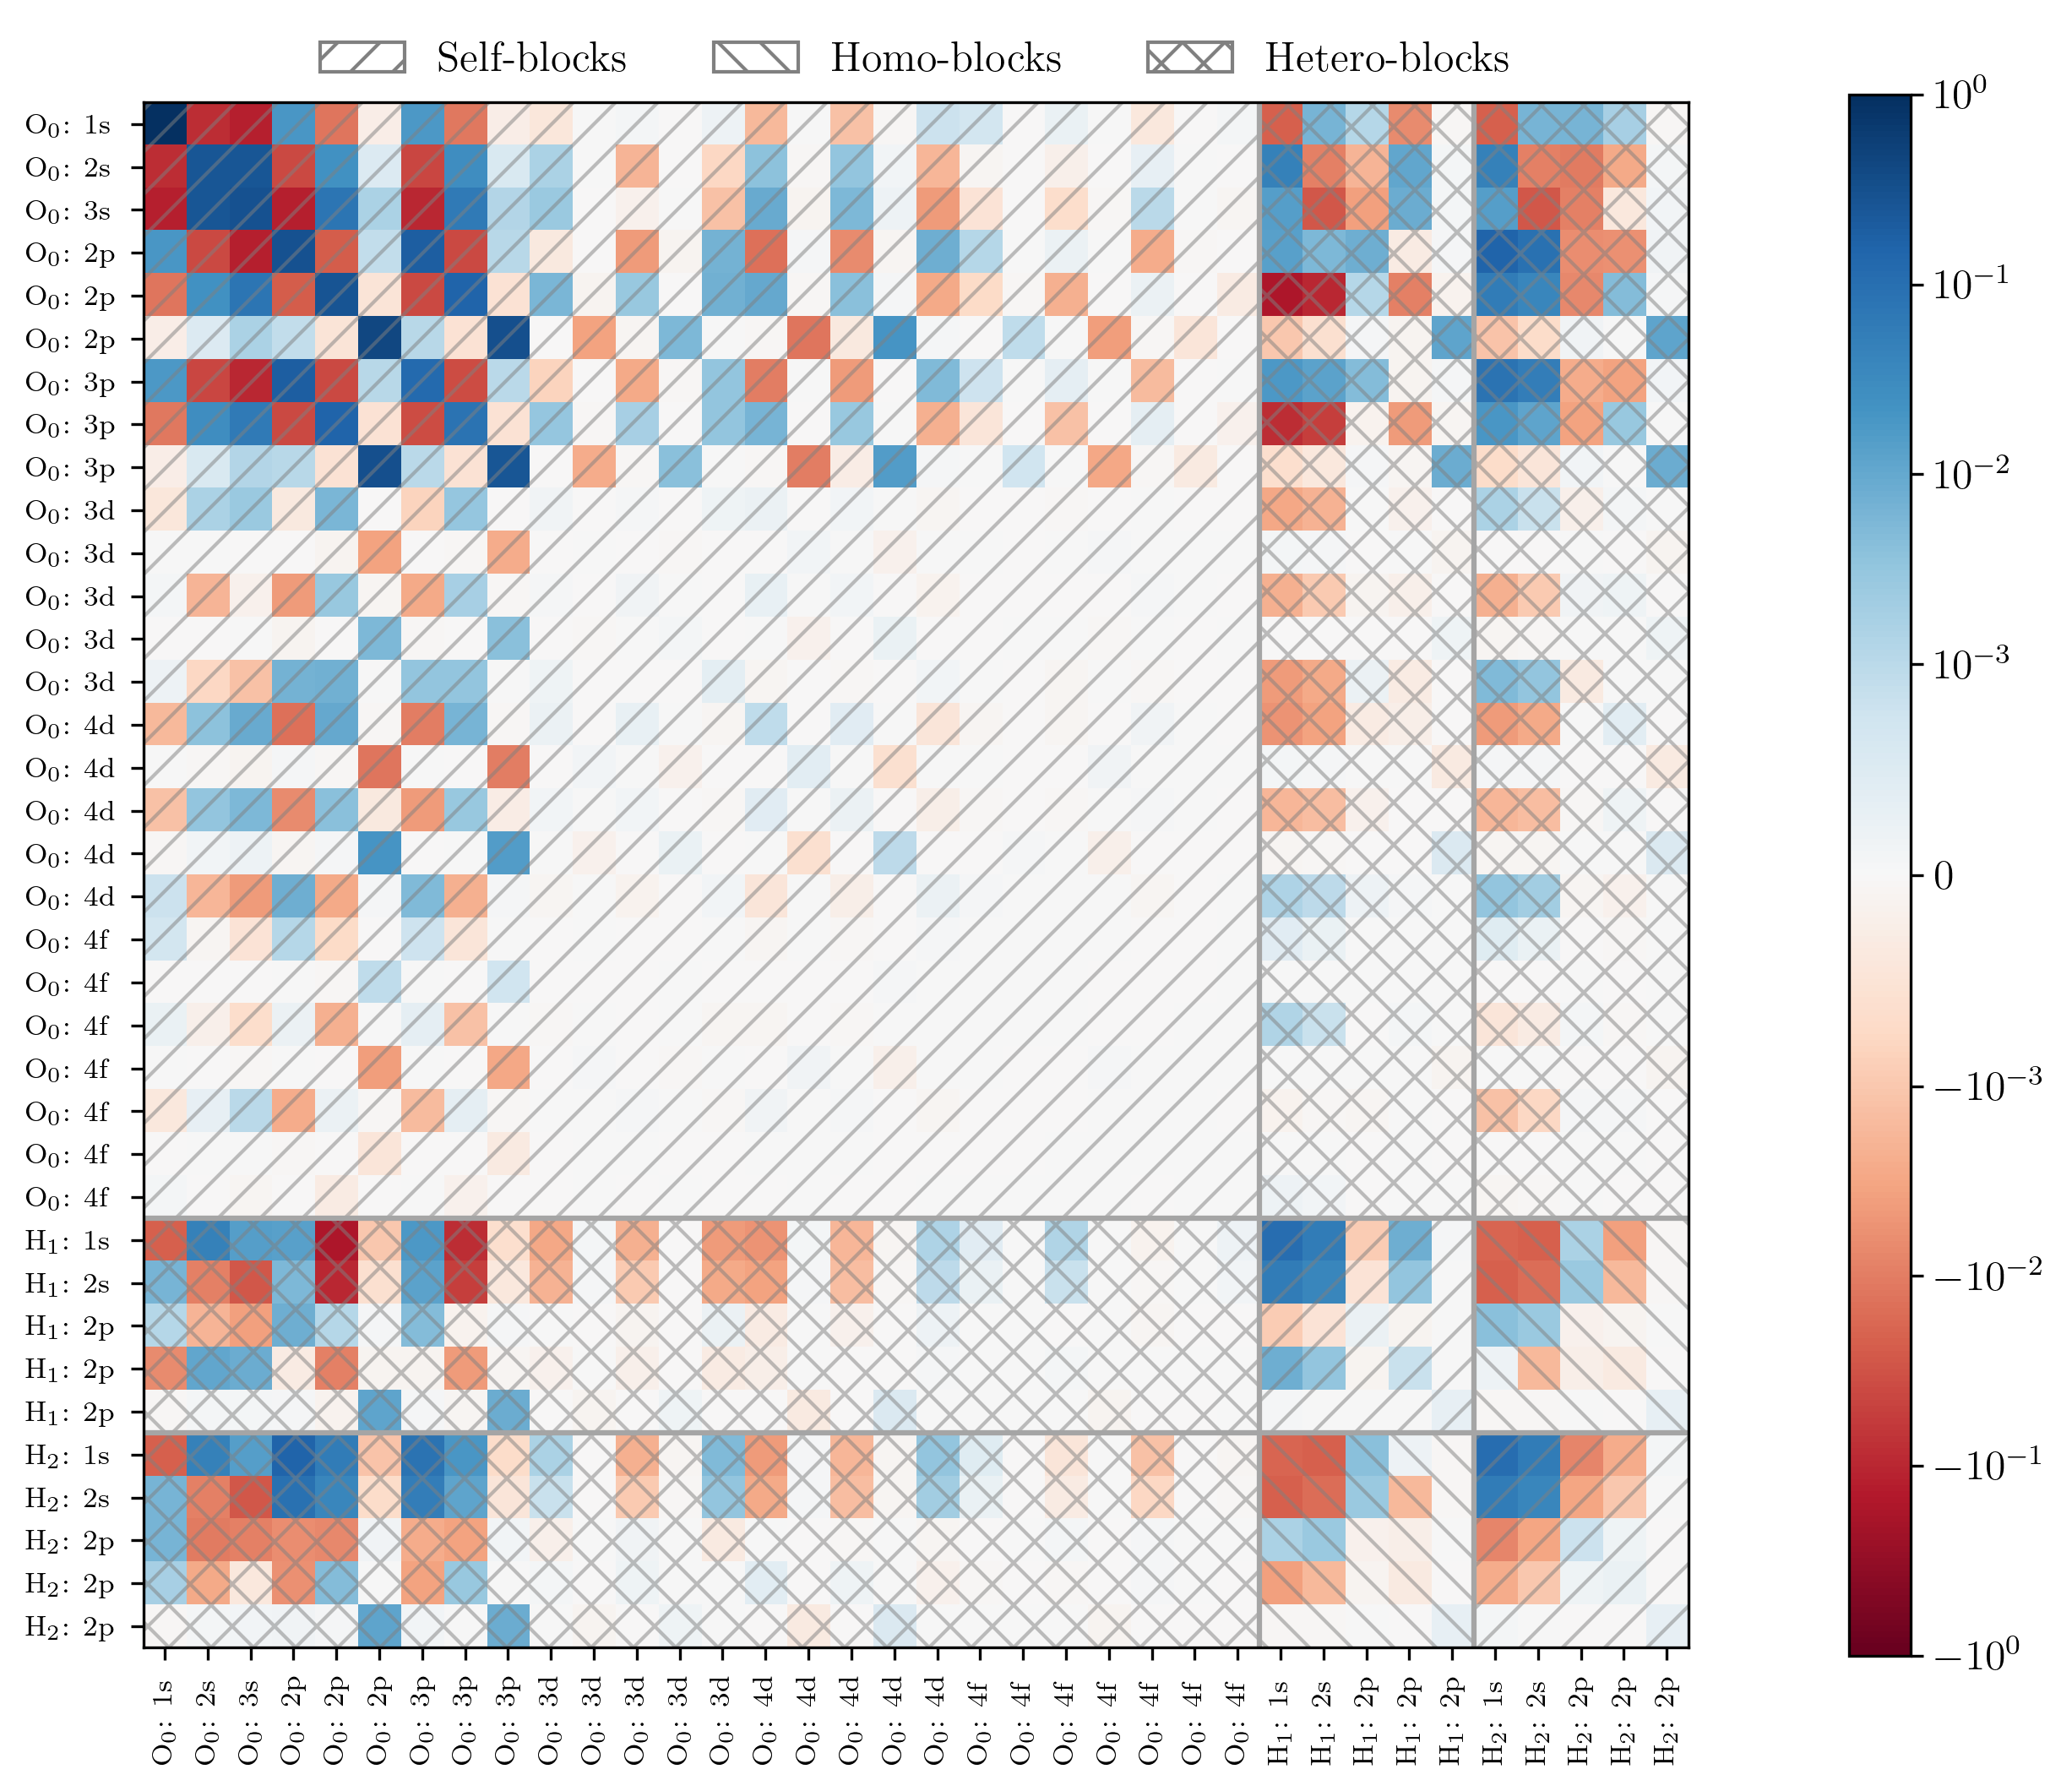

In [91]:
hatches = [
    ("Self-blocks", "//", (0, 25, 0, 25)),  
    ("Self-blocks", "//", (26, 30, 26, 30)),  
    ("Self-blocks", "//", (31, 35, 31, 35)),  
    ("Homo-blocks", "\\\\", (31, 35, 26, 30)),  
    ("Homo-blocks", "\\\\", (26, 30, 31, 35)),  
    ("Hetero-blocks", "xx", (0, 25, 26, 30)),  
    ("Hetero-blocks", "xx", (0, 25, 31, 35)),  
    ("Hetero-blocks", "xx", (26, 30, 0, 25)),  
    ("Hetero-blocks", "xx", (31, 35, 0, 25)),  
]
plotschematicBlocks(density.numpy, mol.native, "../../fig/gnn/schematic_blocks.pdf", vmax=1, hatched_regions=hatches)# labels="atoms")